<h1> Objective:- Assessment Task 5.1C: Deep learning for Computer Vision </h1>

<div style="text-align: right"> Done by: <b>Karan Murjani </b> </div>
<div style="text-align: right"> StudentId: <b> 2210470832 </b></div>

# **2. Deep learning with PyTorch**

**2.1. Building a convolutional neural network**

In [1]:
#Loading all libary
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import glob
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sn
import pandas as pd
from torchvision import datasets
import time

In [2]:
#Transformation on data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
#Define classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


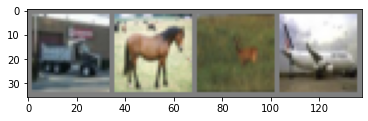

truck horse  deer plane


In [3]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
#Define NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 16 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [5]:
#Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

[1,  2000] loss: 2.197
[1,  4000] loss: 1.915
[1,  6000] loss: 1.692
[1,  8000] loss: 1.595
[1, 10000] loss: 1.515
[1, 12000] loss: 1.474
[2,  2000] loss: 1.432
[2,  4000] loss: 1.393
[2,  6000] loss: 1.366
[2,  8000] loss: 1.360
[2, 10000] loss: 1.333
[2, 12000] loss: 1.297
Finished Training
Training time in 103.77000021934509 seconds ---


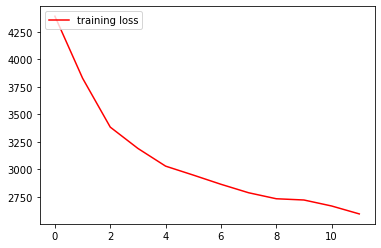

In [6]:
#Train the network
start_time = time.time()
loss_history = []
epoch = 2

for e in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
print('Finished Training')
print("Training time in %s seconds ---" % (time.time() - start_time))
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [7]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

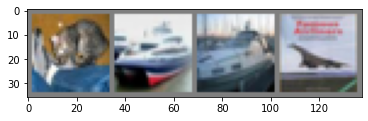

GroundTruth:    cat  ship  ship plane


In [8]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [9]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH))
outputs = net(images)

In [10]:
_, predicted_labels = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
                              for j in range(4)))

Predicted:    cat  ship   car  ship


In [11]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


In [12]:
#Per class accuracy
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        
        outputs = net(images)
        _, predicted_labels = torch.max(outputs, 1)
        
        c = (predicted_labels == groundtruth_labels).squeeze()
        for i in range(4):
            label = groundtruth_labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 81 %
Accuracy of  bird : 54 %
Accuracy of   cat : 30 %
Accuracy of  deer : 35 %
Accuracy of   dog : 38 %
Accuracy of  frog : 63 %
Accuracy of horse : 56 %
Accuracy of  ship : 70 %
Accuracy of truck : 46 %


1) Build Confusion matrix for entire dataset

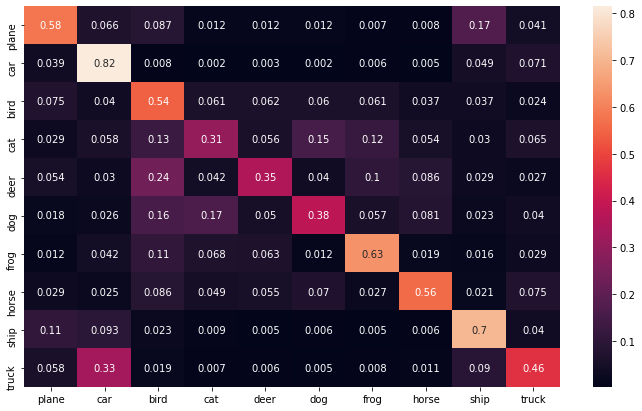

In [13]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
        output = net(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

### 2) Building model for different dataset

In [14]:
#Building model for different dataset
transform = transforms.Compose(
    [transforms.Resize((32,32)), # you can change the image size, but need to change the architecture accordingly
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.ImageFolder('FoodImages/Train', transform=transform)
testset = datasets.ImageFolder('FoodImages/Test', transform=transform)

classes = ('Cakes', 'Pasta', 'Pizza')

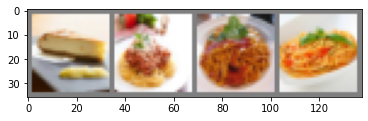

Cakes Pasta Pasta Pasta


In [15]:
batch_size = 4

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

**2.2 Fine-tuning a CNN**

In [16]:
PATH = './cifar_net.pth'
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [17]:
#Changing output node from 10 class to 3 class
net.fc3 = nn.Linear(84, 3)

In [18]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


[1,     4] loss: 0.002
[1,     8] loss: 0.002
[1,    12] loss: 0.002
[1,    16] loss: 0.002
[1,    20] loss: 0.002
[2,     4] loss: 0.002
[2,     8] loss: 0.002
[2,    12] loss: 0.002
[2,    16] loss: 0.002
[2,    20] loss: 0.001
[3,     4] loss: 0.002
[3,     8] loss: 0.001
[3,    12] loss: 0.001
[3,    16] loss: 0.002
[3,    20] loss: 0.001
[4,     4] loss: 0.001
[4,     8] loss: 0.001
[4,    12] loss: 0.002
[4,    16] loss: 0.001
[4,    20] loss: 0.001
[5,     4] loss: 0.001
[5,     8] loss: 0.002
[5,    12] loss: 0.001
[5,    16] loss: 0.001
[5,    20] loss: 0.001
[6,     4] loss: 0.001
[6,     8] loss: 0.001
[6,    12] loss: 0.001
[6,    16] loss: 0.001
[6,    20] loss: 0.001
[7,     4] loss: 0.001
[7,     8] loss: 0.001
[7,    12] loss: 0.001
[7,    16] loss: 0.001
[7,    20] loss: 0.000
[8,     4] loss: 0.000
[8,     8] loss: 0.001
[8,    12] loss: 0.000
[8,    16] loss: 0.001
[8,    20] loss: 0.000
[9,     4] loss: 0.000
[9,     8] loss: 0.000
[9,    12] loss: 0.000
[9,    16] 

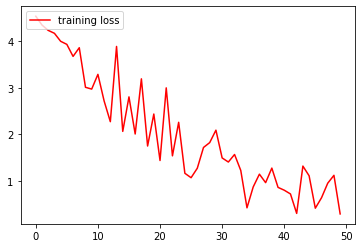

In [19]:
#Train the network
#Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

start_time = time.time()
loss_history = []
epoch = 10

for e in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 4 == 3:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
print('Finished Training')
print("Training time in %s seconds ---" % (time.time() - start_time))
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [20]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
        
print('Accuracy of the network on test images: %d %%' % (100 * correct / total))

Accuracy of the network on test images: 81 %


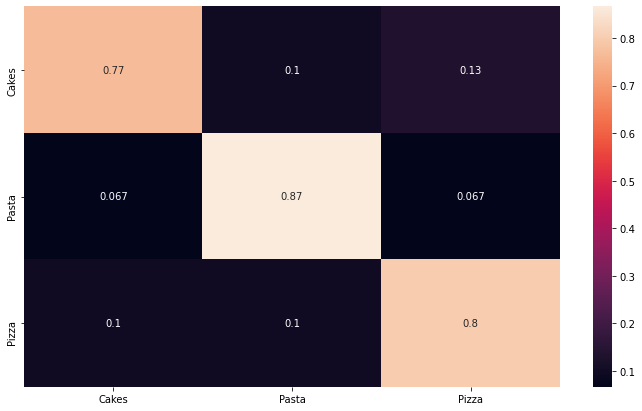

In [21]:
#Confusion matrix
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
    output = net(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Cakes', 'Pasta', 'Pizza')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_report = classification_report(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *3, index = [i for i in classes],
                     columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output_2.png')

In [22]:
#Classification report
print(cf_report)

              precision    recall  f1-score   support

           0       0.82      0.77      0.79        30
           1       0.81      0.87      0.84        30
           2       0.80      0.80      0.80        30

    accuracy                           0.81        90
   macro avg       0.81      0.81      0.81        90
weighted avg       0.81      0.81      0.81        90



### 2) Develop model from scratch

In [23]:
#Define NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 20, 5)
        self.fc1 = nn.Linear(20 * 5 * 5, 60)
        self.fc2 = nn.Linear(60, 30)
        self.fc3 = nn.Linear(30, 3)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #x = self.conv1(x), x = F.relu(x), x = self.pool(x)
        x = self.pool(F.relu(self.conv2(x))) #x = self.conv2(x), x = F.relu(x), x = self.pool(x)
        x = x.view(-1, 20 * 5 * 5) #flatten a 16x5x5 tensor to 16x5x5-dimensional vector
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()

In [24]:
#Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

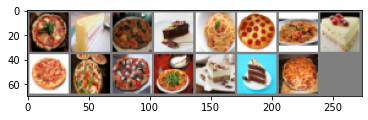

Pizza Cakes Pizza Cakes Pasta Pizza Pasta Cakes Pizza Pizza Pizza Pizza Cakes Cakes Pizza


In [25]:
batch_size = 15

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print true labels of the images
print(' '.join('%5s' % classes[labels[j]] for j in range(15)))

[1,     4] loss: 0.002
[2,     4] loss: 0.002
[3,     4] loss: 0.002
[4,     4] loss: 0.002
[5,     4] loss: 0.001
[6,     4] loss: 0.001
[7,     4] loss: 0.001
[8,     4] loss: 0.001
[9,     4] loss: 0.001
[10,     4] loss: 0.001
[11,     4] loss: 0.001
[12,     4] loss: 0.001
[13,     4] loss: 0.001
[14,     4] loss: 0.000
[15,     4] loss: 0.000
[16,     4] loss: 0.000
[17,     4] loss: 0.000
[18,     4] loss: 0.000
[19,     4] loss: 0.000
[20,     4] loss: 0.000
Finished Training
Training time in 228.42487597465515 seconds ---


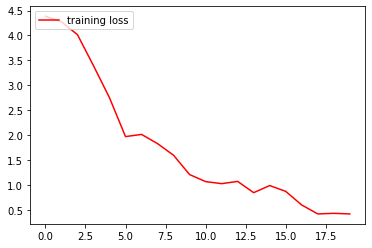

In [26]:
#Train the network
start_time = time.time()

loss_history = []
epoch = 20

for e in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 4 == 3:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (e + 1, i + 1, running_loss / 2000))
            loss_history.append(running_loss)
            running_loss = 0.0
print('Finished Training')
print("Training time in %s seconds ---" % (time.time() - start_time))
plt.plot(loss_history, label = 'training loss', color = 'r')
plt.legend(loc = "upper left")
plt.show()

In [27]:
print(net)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=30, bias=True)
  (fc3): Linear(in_features=30, out_features=3, bias=True)
)


In [28]:
PATH1 = './foodimages.pth'
torch.save(net.state_dict(), PATH1)

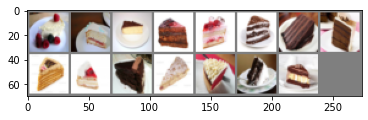

GroundTruth:  Cakes Cakes Cakes Cakes


In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [30]:
#load the trained network
net = Net()
net.load_state_dict(torch.load(PATH1))
outputs = net(images)

In [31]:
_, predicted_labels = torch.max(outputs, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted_labels[j]]
                              for j in range(4)))

Predicted:  Cakes Cakes Cakes Pasta


In [32]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, groundtruth_labels = data
        outputs = net(images)
        _, predicted_labels = torch.max(outputs.data, 1)
        total += groundtruth_labels.size(0)
        correct += (predicted_labels == groundtruth_labels).sum().item()
print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))

Accuracy of the network on the test images: 83 %


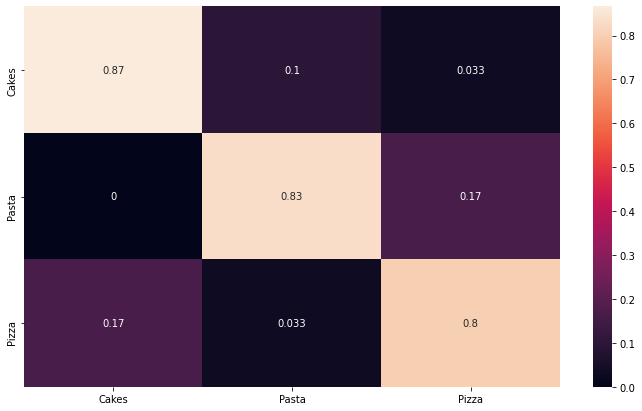

In [33]:
#Confusion matrix
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in testloader:
    output = net(inputs) # Feed Network

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('Cakes', 'Pasta', 'Pizza')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
cf_report = classification_report(y_true, y_pred)

df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *3, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('output_3.png')

In [34]:
#Classification report
print(cf_report)

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        30
           1       0.86      0.83      0.85        30
           2       0.80      0.80      0.80        30

    accuracy                           0.83        90
   macro avg       0.83      0.83      0.83        90
weighted avg       0.83      0.83      0.83        90

